# Proyek Klasifikasi Gambar: CATS and DOGS
- **Nama:** FAIZAL RIZA
- **Email:** akuisal@gmail.com
- **ID Dicoding:** akuisal@gmail.com

## Import Semua Packages/Library yang Digunakan

In [1]:
# Install TensorFlow
!pip install tensorflow
!pip install tensorflow-text

# Install package lain yang diperlukan
!pip install opencv-python
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflowjs

# Install kaggle package untuk mengunduh dataset
!pip install kaggle

# Import library
import os
import cv2
import shutil
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split


# Check TensorFlow version
print("TensorFlow Version:", tf.__version__)

# Check if GPU is available
print("GPU Available:", tf.test.is_gpu_available())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow Version: 2.18.0
GPU Available: True


## Data Preparation

### Data Loading

In [2]:
# Setup Kaggle API (Anda perlu mengunggah kaggle.json)
from google.colab import files
files.upload()  # Unggah file kaggle.json Anda
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset dari Kaggle
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset
!unzip -q microsoft-catsvsdogs-dataset.zip -d dataset

# Definisikan path dataset
data_dir = '/content/dataset/PetImages'
categories = ['Cat', 'Dog']


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other


### Data Preprocessing

In [3]:
# Fungsi untuk membuat daftar path gambar dan label
def create_image_dataframe(data_dir, categories):
    image_paths = []
    labels = []

    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)  # 0 untuk Cat, 1 untuk Dog

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            # Validasi apakah file adalah gambar
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(img_path)
                labels.append(class_num)
            else:
                print(f"Skipped non-image file: {img_name}")

    # Buat DataFrame
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    df['label_name'] = df['label'].map({0: 'Cat', 1: 'Dog'})
    return df

# Buat DataFrame
df = create_image_dataframe(data_dir, categories)

Skipped non-image file: Thumbs.db
Skipped non-image file: Thumbs.db


## Daftar Nama Kelas

In [4]:
# Daftar nama kelas
class_names = categories
print("Class Names:", class_names)
print("Total Images:", len(df))
print("DataFrame Head:")
print(df.head())
print("Label Distribution:")
print(df['label_name'].value_counts())

Class Names: ['Cat', 'Dog']
Total Images: 25000
DataFrame Head:
                                image_path  label label_name
0  /content/dataset/PetImages/Cat/2860.jpg      0        Cat
1  /content/dataset/PetImages/Cat/5304.jpg      0        Cat
2  /content/dataset/PetImages/Cat/4699.jpg      0        Cat
3  /content/dataset/PetImages/Cat/6642.jpg      0        Cat
4   /content/dataset/PetImages/Cat/217.jpg      0        Cat
Label Distribution:
label_name
Cat    12500
Dog    12500
Name: count, dtype: int64


### Plot Sampel Gambar

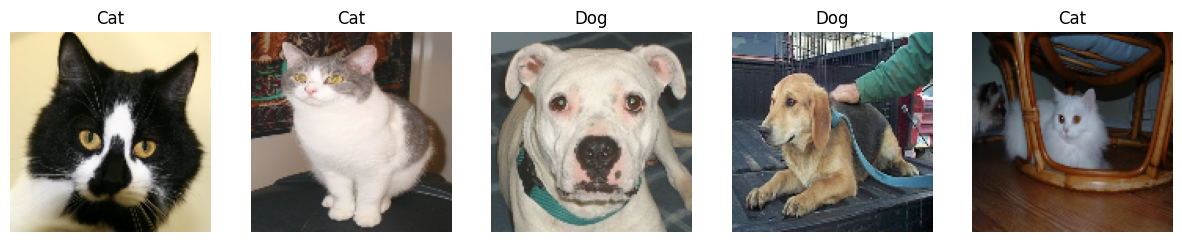

In [5]:
# Fungsi untuk memuat dan menampilkan sampel gambar
def plot_sample_images(df, class_names, num_samples=5, img_size=128):
    plt.figure(figsize=(15, 5))
    sample_df = df.sample(num_samples)

    for i, row in enumerate(sample_df.itertuples()):
        img = cv2.imread(row.image_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(class_names[row.label])
        plt.axis('off')
    plt.show()

# Tampilkan sampel gambar
plot_sample_images(df, class_names)


#Building Distribution Data
Label Distribution:
label_name
Cat    12500
Dog    12500
Name: count, dtype: int64


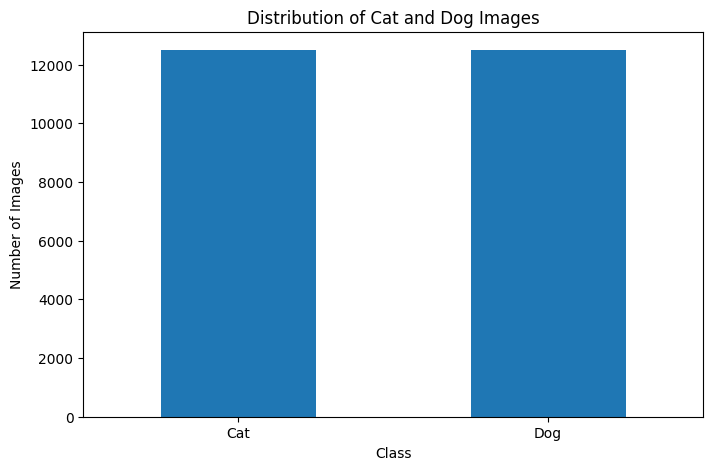

In [6]:
# Building Distribution Data
print("\n#Building Distribution Data")
label_counts = df['label_name'].value_counts()
print("Label Distribution:")
print(label_counts)

# Visualisasi distribusi data
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar')
plt.title('Distribution of Cat and Dog Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()

#### **Split Dataset**

**Dataset Dibagi Menjadi Train Set, Test Set dan Validation Set**

In [7]:
# Import library yang diperlukan
from sklearn.model_selection import train_test_split

# Split dataset menjadi train, validation, dan test set
def split_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15):
    # Pastikan proporsi total = 1
    assert train_size + val_size + test_size == 1, "Proporsi split harus berjumlah 1"

    # Split train dan temp (val + test)
    df_train, df_temp = train_test_split(
        df,
        train_size=train_size,
        stratify=df['label'],
        random_state=42
    )

    # Split temp menjadi validation dan test
    val_relative_size = val_size / (val_size + test_size)
    df_val, df_test = train_test_split(
        df_temp,
        train_size=val_relative_size,
        stratify=df_temp['label'],
        random_state=42
    )

    return df_train, df_val, df_test

# Lakukan splitting
df_train, df_val, df_test = split_dataset(df)

# Tampilkan informasi hasil split
print("Train Set Size:", len(df_train))
print("Validation Set Size:", len(df_val))
print("Test Set Size:", len(df_test))


Train Set Size: 17500
Validation Set Size: 3750
Test Set Size: 3750


Count data image


Train Set Label Distribution:
label_name
Dog    8750
Cat    8750
Name: count, dtype: int64

Validation Set Label Distribution:
label_name
Dog    1875
Cat    1875
Name: count, dtype: int64

Test Set Label Distribution:
label_name
Dog    1875
Cat    1875
Name: count, dtype: int64


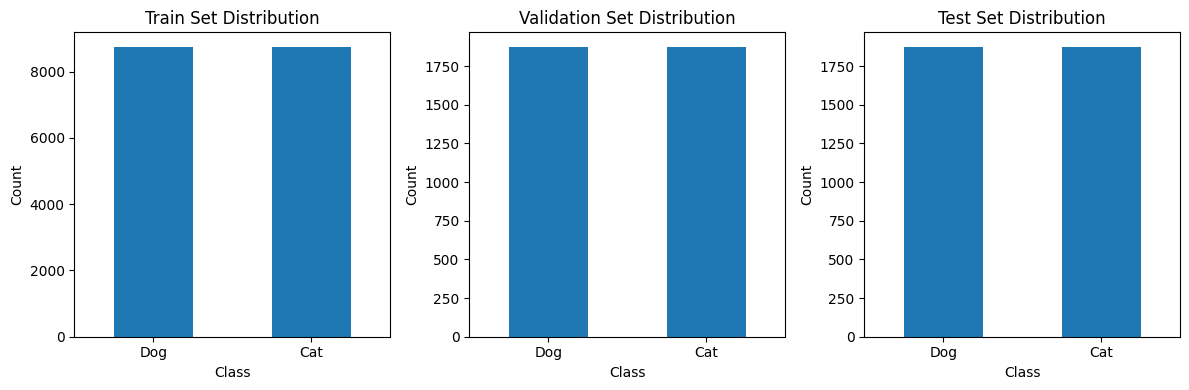

In [8]:
# Tampilkan distribusi kelas di setiap set
print("\nTrain Set Label Distribution:")
print(df_train['label_name'].value_counts())
print("\nValidation Set Label Distribution:")
print(df_val['label_name'].value_counts())
print("\nTest Set Label Distribution:")
print(df_test['label_name'].value_counts())

# Visualisasi distribusi kelas
import matplotlib.pyplot as plt

def plot_split_distribution(df_train, df_val, df_test):
    plt.figure(figsize=(12, 4))

    # Train set
    plt.subplot(1, 3, 1)
    df_train['label_name'].value_counts().plot(kind='bar')
    plt.title('Train Set Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    # Validation set
    plt.subplot(1, 3, 2)
    df_val['label_name'].value_counts().plot(kind='bar')
    plt.title('Validation Set Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    # Test set
    plt.subplot(1, 3, 3)
    df_test['label_name'].value_counts().plot(kind='bar')
    plt.title('Test Set Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()

# Tampilkan visualisasi distribusi
plot_split_distribution(df_train, df_val, df_test)

## **Prepare Dataset**

In [9]:
# Fungsi untuk mempersiapkan DataFrame
def prepare_dataframe(df, set_name):
    # Pastikan kolom label_name adalah string (diperlukan untuk ImageDataGenerator)
    df['label_name'] = df['label_name'].astype(str)

    # Tampilkan informasi DataFrame
    print(f"\n{set_name} DataFrame Info:")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Sample Data:")
    print(df.head())
    print("Label Distribution:")
    print(df['label_name'].value_counts())

    return df

# Persiapkan DataFrame untuk train, validation, dan test
df_train = prepare_dataframe(df_train, "Train")
df_val = prepare_dataframe(df_val, "Validation")
df_test = prepare_dataframe(df_test, "Test")

# Simpan DataFrame ke file CSV (opsional, untuk debugging atau referensi)
df_train.to_csv('train_dataset.csv', index=False)
df_val.to_csv('validation_dataset.csv', index=False)
df_test.to_csv('test_dataset.csv', index=False)
print("\nDataFrames telah disimpan sebagai CSV: train_dataset.csv, validation_dataset.csv, test_dataset.csv")


Train DataFrame Info:
Shape: (17500, 3)
Columns: ['image_path', 'label', 'label_name']
Sample Data:
                                    image_path  label label_name
24393  /content/dataset/PetImages/Dog/4935.jpg      1        Dog
10884  /content/dataset/PetImages/Cat/5087.jpg      0        Cat
16419  /content/dataset/PetImages/Dog/4899.jpg      1        Dog
6596   /content/dataset/PetImages/Cat/6495.jpg      0        Cat
12718  /content/dataset/PetImages/Dog/9335.jpg      1        Dog
Label Distribution:
label_name
Dog    8750
Cat    8750
Name: count, dtype: int64

Validation DataFrame Info:
Shape: (3750, 3)
Columns: ['image_path', 'label', 'label_name']
Sample Data:
                                     image_path  label label_name
13100   /content/dataset/PetImages/Dog/8755.jpg      1        Dog
9908    /content/dataset/PetImages/Cat/2006.jpg      0        Cat
10301  /content/dataset/PetImages/Cat/11286.jpg      0        Cat
3310    /content/dataset/PetImages/Cat/6202.jpg      0     

### **Image Data Generator**

Found 17500 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.
Train Generator Classes: {'Cat': 0, 'Dog': 1}
Validation Generator Classes: {'Cat': 0, 'Dog': 1}
Test Generator Classes: {'Cat': 0, 'Dog': 1}
Train Samples: 17500
Validation Samples: 3750
Test Samples: 3750

Sample Augmented Images from Train Generator:


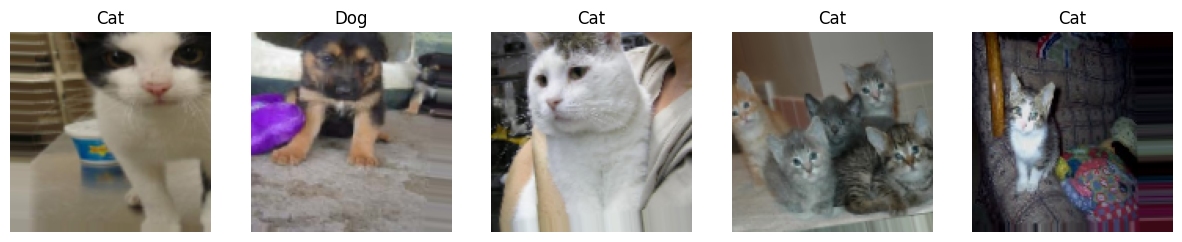

In [10]:
# Import library yang diperlukan
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definisikan parameter
IMG_SIZE = 128  # Ukuran gambar
BATCH_SIZE = 32  # Ukuran batch untuk efisiensi memori

# Buat ImageDataGenerator untuk train dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi gambar
    rotation_range=20,  # Rotasi acak hingga 20 derajat
    width_shift_range=0.2,  # Pergeseran lebar
    height_shift_range=0.2,  # Pergeseran tinggi
    shear_range=0.2,  # Transformasi shear
    zoom_range=0.2,  # Zoom acak
    horizontal_flip=True,  # Flip horizontal
    fill_mode='nearest'  # Cara mengisi piksel kosong
)

# Buat ImageDataGenerator untuk validation dan test (tanpa augmentasi, hanya normalisasi)
val_test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalisasi gambar
)

# Buat generator untuk train set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image_path',
    y_col='label_name',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Karena klasifikasi biner (Cat vs Dog)
    shuffle=True
)

# Buat generator untuk validation set
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='image_path',
    y_col='label_name',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Buat generator untuk test set
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image_path',
    y_col='label_name',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Tampilkan informasi generator
print("Train Generator Classes:", train_generator.class_indices)
print("Validation Generator Classes:", validation_generator.class_indices)
print("Test Generator Classes:", test_generator.class_indices)
print(f"Train Samples: {train_generator.samples}")
print(f"Validation Samples: {validation_generator.samples}")
print(f"Test Samples: {test_generator.samples}")

# Visualisasi beberapa gambar dari train generator (dengan augmentasi)
import matplotlib.pyplot as plt

def plot_augmented_images(generator, num_samples=5):
    # Ambil satu batch gambar
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 5))
    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
    plt.show()

# Tampilkan sampel gambar yang telah diaugmentasi dari train generator
print("\nSample Augmented Images from Train Generator:")
plot_augmented_images(train_generator)

## Modelling

In [15]:
# Definisikan parameter
IMG_SIZE = 128  # Sesuai dengan tahap 5
NUM_CLASSES = 1  # Karena klasifikasi biner (output sigmoid)

# Buat arsitektur CNN
model = models.Sequential([
    # Layer 1: Konvolusi + Pooling
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),

    # Layer 2: Konvolusi + Pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Layer 3: Konvolusi + Pooling
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten untuk mengubah ke vektor
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout untuk mencegah overfitting
    layers.Dense(NUM_CLASSES, activation='sigmoid')  # Output biner
])

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Tampilkan ringkasan model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### **Implementasi Callback**

In [16]:
# Import library yang diperlukan
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Definisikan direktori untuk menyimpan model sementara
checkpoint_dir = 'checkpoints'

# Definisikan callback
callbacks = [
    # EarlyStopping: Hentikan training jika val_accuracy tidak membaik
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    # ModelCheckpoint: Simpan model terbaik dalam format .keras
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'checkpoint.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    # ReduceLROnPlateau: Kurangi learning rate jika val_accuracy stagnan
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Buat direktori checkpoint jika belum ada
os.makedirs(checkpoint_dir, exist_ok=True)

# Tampilkan informasi callback
print("Callbacks yang akan digunakan:")
for callback in callbacks:
    print(f"- {callback.__class__.__name__}")
print(f"\nModel sementara akan disimpan di '{checkpoint_dir}/checkpoint.keras'.")
print("Model akhir akan disimpan dalam format SavedModel di direktori 'saved_model' setelah pelatihan.")

Callbacks yang akan digunakan:
- EarlyStopping
- ModelCheckpoint
- ReduceLROnPlateau

Model sementara akan disimpan di 'checkpoints/checkpoint.keras'.
Model akhir akan disimpan dalam format SavedModel di direktori 'saved_model' setelah pelatihan.


### **Training Model**

In [17]:
# Import library yang diperlukan
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Fungsi untuk memvalidasi file gambar
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verifikasi integritas file
        img.close()
        return True
    except Exception as e:
        print(f"Invalid image file: {file_path} - {str(e)}")
        return False

# Filter DataFrame untuk hanya menyertakan file gambar yang valid
def filter_valid_images(df):
    valid_rows = []
    invalid_files = []

    for idx, row in df.iterrows():
        if is_valid_image(row['image_path']):
            valid_rows.append(row)
        else:
            invalid_files.append(row['image_path'])

    valid_df = pd.DataFrame(valid_rows, columns=df.columns)
    print(f"Total invalid files skipped: {len(invalid_files)}")
    if invalid_files:
        print("Sample invalid files:", invalid_files[:5])
    return valid_df

# Terapkan filter ke DataFrame (train, validation, test)
print("Filtering invalid images...")
df_train = filter_valid_images(df_train)
df_val = filter_valid_images(df_val)
df_test = filter_valid_images(df_test)

# Perbarui generator dengan DataFrame yang sudah difilter
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image_path',
    y_col='label_name',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='image_path',
    y_col='label_name',
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Filtering invalid images...


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Invalid image file: /content/dataset/PetImages/Dog/11702.jpg - cannot identify image file '/content/dataset/PetImages/Dog/11702.jpg'
Total invalid files skipped: 1
Sample invalid files: ['/content/dataset/PetImages/Dog/11702.jpg']
Invalid image file: /content/dataset/PetImages/Cat/666.jpg - cannot identify image file '/content/dataset/PetImages/Cat/666.jpg'
Total invalid files skipped: 1
Sample invalid files: ['/content/dataset/PetImages/Cat/666.jpg']
Total invalid files skipped: 0
Found 17499 validated image filenames belonging to 2 classes.
Found 3749 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
519/547 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.5621 - loss: 0.6781

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5635 - loss: 0.6774
Epoch 1: val_accuracy improved from -inf to 0.63510, saving model to checkpoints/checkpoint.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 112s 193ms/step - accuracy: 0.5636 - loss: 0.6774 - val_accuracy: 0.6351 - val_loss: 0.6376 - learning_rate: 0.0010
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6525 - loss: 0.6248
Epoch 2: val_accuracy improved from 0.63510 to 0.68418, saving model to checkpoints/checkpoint.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 141s 198ms/step - accuracy: 0.6525 - loss: 0.6248 - val_accuracy: 0.6842 - val_loss: 0.5842 - learning_rate: 0.0010
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6788 - loss: 0.5880
Epoch 3: val_accuracy improved from 0.68418 to 0.74820, saving model to checkpoints/checkpoint.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 103s 188ms/step - accuracy: 0.6788 - loss: 0.5879 - val_accuracy: 0.7482 - val_loss: 0.4975 - learning_rate: 0.0010
Epoch 4/20
5

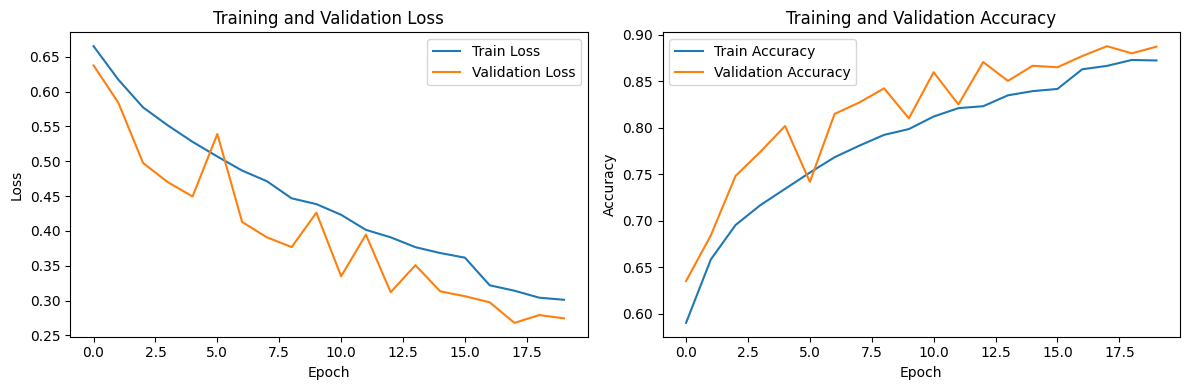

In [18]:
# Definisikan parameter training
EPOCHS = 20

# Latih model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# Simpan model dalam format SavedModel setelah pelatihan
saved_model_dir = 'saved_model'
try:
    model.save(saved_model_dir, save_format='tf')
    print(f"\nModel telah disimpan dalam format SavedModel di '{saved_model_dir}'.")
    # Verifikasi isi direktori
    print(f"Isi {saved_model_dir}:")
    for item in os.listdir(saved_model_dir):
        print(f"- {item}")
except Exception as e:
    print(f"Error saat menyimpan SavedModel: {e}")

# Tampilkan ringkasan hasil training
print("\nTraining selesai!")
print("Akurasi terbaik pada validation set:", max(history.history['val_accuracy']))

# Visualisasi loss dan akurasi
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot akurasi
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Tampilkan plot hasil training
plot_training_history(history)

In [22]:
# Simpan model dalam format .keras (cadangan)
keras_model_path = 'model.keras'
try:
    model.save(keras_model_path)
    print(f"\nModel telah disimpan dalam format .keras di '{keras_model_path}'.")
except Exception as e:
    print(f"Error saat menyimpan model .keras: {e}")

# Simpan model dalam format SavedModel
saved_model_dir = 'saved_model'
try:
    tf.saved_model.save(model, saved_model_dir)
    print(f"Model telah disimpan dalam format SavedModel di '{saved_model_dir}'.")
    # Verifikasi isi direktori
    print(f"Isi {saved_model_dir}:")
    for item in os.listdir(saved_model_dir):
        print(f"- {item}")
except Exception as e:
    print(f"Error saat menyimpan SavedModel: {e}")


Model telah disimpan dalam format .keras di 'model.keras'.
Model telah disimpan dalam format SavedModel di 'saved_model'.
Isi saved_model:
- saved_model.pb
- variables
- assets
- fingerprint.pb


## Evaluasi dan Visualisasi

118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.8880 - loss: 0.2623

Test Loss: 0.2754
Test Accuracy: 0.8859
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step


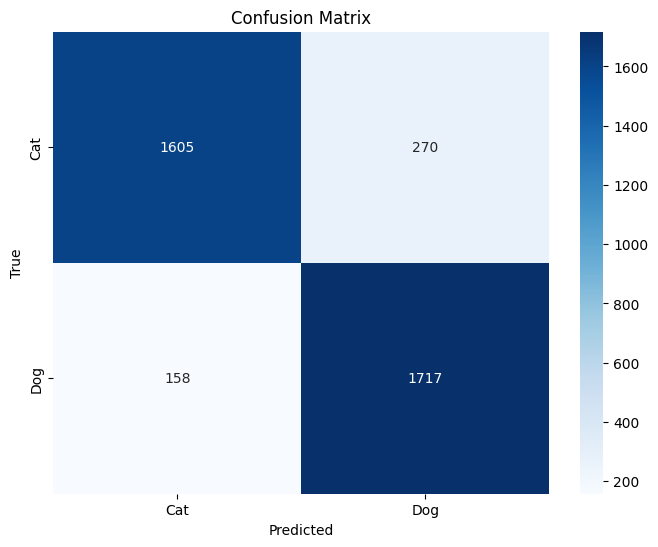


Classification Report:
              precision    recall  f1-score   support

         Cat       0.91      0.86      0.88      1875
         Dog       0.86      0.92      0.89      1875

    accuracy                           0.89      3750
   macro avg       0.89      0.89      0.89      3750
weighted avg       0.89      0.89      0.89      3750


Sample Predictions on Test Set:


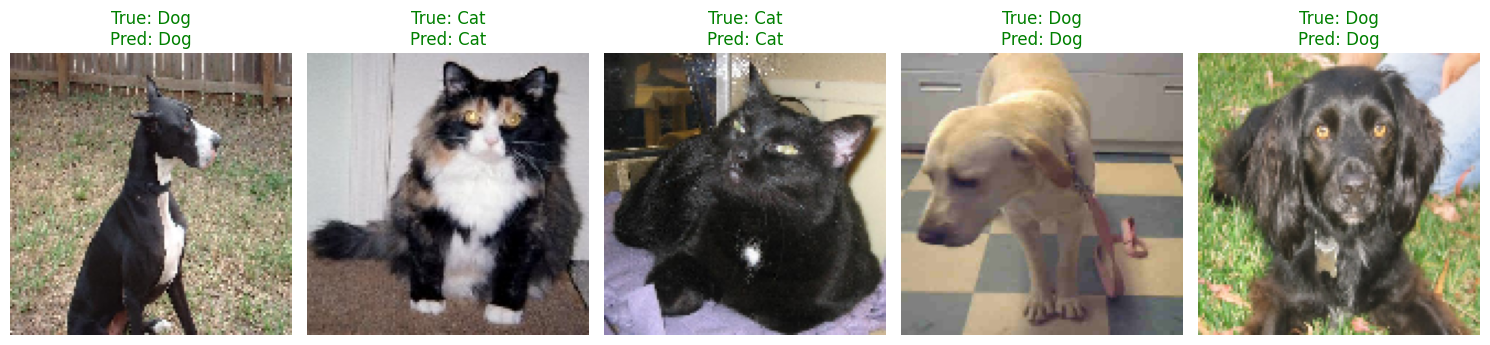

In [19]:
# Import library evaluasi
from sklearn.metrics import confusion_matrix, classification_report

# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Prediksi pada test set
test_generator.reset()  # Reset generator untuk memastikan urutan benar
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Konversi probabilitas ke kelas (0 atau 1)
y_true = test_generator.classes  # Label sebenarnya dari test_generator

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(test_generator.class_indices.keys())  # ['Cat', 'Dog']

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Visualisasi beberapa prediksi pada test set
def plot_sample_predictions(generator, y_true, y_pred_classes, class_names, num_samples=5):
    generator.reset()  # Reset generator
    images, labels = next(generator)  # Ambil batch pertama
    indices = np.random.choice(len(images), num_samples, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[idx])
        true_label = class_names[int(labels[idx])]
        pred_label = class_names[y_pred_classes[idx]]
        title = f"True: {true_label}\nPred: {pred_label}"
        plt.title(title, color='green' if true_label == pred_label else 'red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Tampilkan beberapa prediksi
print("\nSample Predictions on Test Set:")
plot_sample_predictions(test_generator, y_true, y_pred_classes, class_names)

In [23]:
# Definisikan path SavedModel
saved_model_dir = 'saved_model'

# Verifikasi keberadaan SavedModel
if not os.path.exists(saved_model_dir):
    raise FileNotFoundError(f"Direktori SavedModel '{saved_model_dir}' tidak ditemukan.")

# Konversi model ke format TFLite
try:
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
    tflite_model = converter.convert()
    print("Model SavedModel berhasil dikonversi ke TFLite.")
except Exception as e:
    print(f"Error saat mengonversi model ke TFLite: {e}")
    raise

# Simpan model TFLite ke file
tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Tampilkan ukuran file TFLite
tflite_size = os.path.getsize(tflite_model_path) / (1024 * 1024)  # Ukuran dalam MB
print(f"\nModel TFLite telah disimpan sebagai '{tflite_model_path}'")
print(f"Ukuran file TFLite: {tflite_size:.2f} MB")

# Verifikasi model TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
print("Model TFLite berhasil diverifikasi.")

Model SavedModel berhasil dikonversi ke TFLite.

Model TFLite telah disimpan sebagai 'model.tflite'
Ukuran file TFLite: 0.01 MB
Model TFLite berhasil diverifikasi.


## **Konversi Model**

## **TFLite**

In [24]:
# Bagian 1: Verifikasi Model TFLite
tflite_model_path = 'model.tflite'
try:
    # Muat dan verifikasi model TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    print("Model TFLite berhasil dimuat dan diverifikasi.")

    # Tampilkan detail input dan output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    print("Input Details:", input_details)
    print("Output Details:", output_details)
except Exception as e:
    print(f"Error saat memuat model TFLite: {e}")

Model TFLite berhasil dimuat dan diverifikasi.
Input Details: [{'name': 'serving_default_inputs:0', 'index': 0, 'shape': array([  1, 128, 128,   3], dtype=int32), 'shape_signature': array([ -1, 128, 128,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output Details: [{'name': 'StatefulPartitionedCall:0', 'index': 45, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


## **TFJS**

In [25]:
# Bagian 2: Konversi Model ke TensorFlow.js
saved_model_dir = 'saved_model'
tfjs_model_dir = 'tfjs_model'

try:
    # Konversi langsung dari SavedModel ke TFJS
    tfjs.converters.convert_tf_saved_model(saved_model_dir, tfjs_model_dir)
    print(f"\nModel TensorFlow.js telah disimpan di direktori '{tfjs_model_dir}'")

    # Tampilkan isi direktori TFJS
    print("Isi direktori TFJS:")
    for file in os.listdir(tfjs_model_dir):
        print(f"- {file}")
except Exception as e:
    print(f"Error saat mengonversi model ke TFJS: {e}")


Model TensorFlow.js telah disimpan di direktori 'tfjs_model'
Isi direktori TFJS:
- group1-shard1of4.bin
- model.json
- group1-shard4of4.bin
- group1-shard2of4.bin
- group1-shard3of4.bin


**ZIP Model TFJS**

In [26]:
# Bagian 3: Kompresi folder tfjs_model menjadi ZIP
tfjs_zip_path = 'tfjs_model.zip'
try:
    shutil.make_archive('tfjs_model', 'zip', tfjs_model_dir)
    print(f"\nFolder '{tfjs_model_dir}' telah dikompresi menjadi '{tfjs_zip_path}'")
except Exception as e:
    print(f"Error saat mengompresi folder TFJS: {e}")

# Tampilkan ukuran file TFLite dan direktori TFJS
tflite_size = os.path.getsize(tflite_model_path) / (1024 * 1024)  # Ukuran dalam MB
print(f"\nUkuran file TFLite: {tflite_size:.2f} MB")

tfjs_size = sum(os.path.getsize(os.path.join(tfjs_model_dir, f)) for f in os.listdir(tfjs_model_dir)) / (1024 * 1024)
print(f"Ukuran total direktori TFJS: {tfjs_size:.2f} MB")

tfjs_zip_size = os.path.getsize(tfjs_zip_path) / (1024 * 1024)  # Ukuran dalam MB
print(f"Ukuran file ZIP TFJS: {tfjs_zip_size:.2f} MB")


Folder 'tfjs_model' telah dikompresi menjadi 'tfjs_model.zip'

Ukuran file TFLite: 0.01 MB
Ukuran total direktori TFJS: 12.62 MB
Ukuran file ZIP TFJS: 11.81 MB


## **Download Model**

In [29]:
# Import library yang diperlukan
from google.colab import files
import zipfile

# Definisikan path file dan direktori
saved_model_dir = 'saved_model'
tfjs_model_dir = 'tfjs_model'
keras_model_path = 'model.keras'
tflite_model_path = 'model.tflite'
test_dataset_path = 'test_dataset.csv'
train_dataset_path = 'train_dataset.csv'
validation_dataset_path = 'validation_dataset.csv'
output_zip = 'faizalriza_savedModel.zip'

# Verifikasi keberadaan file dan direktori
print("Memeriksa keberadaan file dan direktori untuk di-zip:")
files_to_zip = [
    (saved_model_dir, "direktori"),
    (tfjs_model_dir, "direktori"),
    (keras_model_path, "file"),
    (tflite_model_path, "file"),
    (test_dataset_path, "file"),
    (train_dataset_path, "file"),
    (validation_dataset_path, "file")
]

all_files_exist = True
for path, type_ in files_to_zip:
    if os.path.exists(path):
        print(f"- {path} ({type_}) ditemukan.")
        if type_ == "direktori":
            print(f"  Isi {path}:")
            for item in os.listdir(path):
                print(f"    - {item}")
    else:
        print(f"- {path} ({type_}) tidak ditemukan!")
        all_files_exist = False

if not all_files_exist:
    print("\nPeringatan: Beberapa file/direktori tidak ditemukan. Proses kompresi tetap akan dilanjutkan dengan file yang ada.")

# Buat file ZIP
try:
    print(f"\nMengompresi file ke '{output_zip}'...")
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Tambahkan folder saved_model
        if os.path.exists(saved_model_dir):
            for root, _, files in os.walk(saved_model_dir):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, start=os.path.dirname(saved_model_dir))
                    zipf.write(file_path, arcname)
            print(f"- {saved_model_dir} ditambahkan ke ZIP.")

        # Tambahkan folder tfjs_model
        if os.path.exists(tfjs_model_dir):
            for root, _, files in os.walk(tfjs_model_dir):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, start=os.path.dirname(tfjs_model_dir))
                    zipf.write(file_path, arcname)
            print(f"- {tfjs_model_dir} ditambahkan ke ZIP.")

        # Tambahkan file individu
        for file_path in [keras_model_path, tflite_model_path, test_dataset_path, train_dataset_path, validation_dataset_path]:
            if os.path.exists(file_path):
                arcname = os.path.basename(file_path)
                zipf.write(file_path, arcname)
                print(f"- {file_path} ditambahkan ke ZIP.")

    # Tampilkan ukuran file ZIP
    zip_size = os.path.getsize(output_zip) / (1024 * 1024)  # Ukuran dalam MB
    print(f"\nFile '{output_zip}' berhasil dibuat.")
    print(f"Ukuran file ZIP: {zip_size:.2f} MB")

except Exception as e:
    print(f"Error saat mengompresi file: {e}")
    raise

# Unduh file ZIP
try:
    print(f"\nMengunduh '{output_zip}'...")
    files.download(output_zip)
except Exception as e:
    print(f"Error saat mengunduh {output_zip}: {e}")

Memeriksa keberadaan file dan direktori untuk di-zip:
- saved_model (direktori) ditemukan.
  Isi saved_model:
    - saved_model.pb
    - variables
    - assets
    - fingerprint.pb
- tfjs_model (direktori) ditemukan.
  Isi tfjs_model:
    - group1-shard1of4.bin
    - model.json
    - group1-shard4of4.bin
    - group1-shard2of4.bin
    - group1-shard3of4.bin
- model.keras (file) ditemukan.
- model.tflite (file) ditemukan.
- test_dataset.csv (file) ditemukan.
- train_dataset.csv (file) ditemukan.
- validation_dataset.csv (file) ditemukan.

Mengompresi file ke 'faizalriza_savedModel.zip'...
- saved_model ditambahkan ke ZIP.
- tfjs_model ditambahkan ke ZIP.
- model.keras ditambahkan ke ZIP.
- model.tflite ditambahkan ke ZIP.
- test_dataset.csv ditambahkan ke ZIP.
- train_dataset.csv ditambahkan ke ZIP.
- validation_dataset.csv ditambahkan ke ZIP.

File 'faizalriza_savedModel.zip' berhasil dibuat.
Ukuran file ZIP: 66.45 MB

Mengunduh 'faizalriza_savedModel.zip'...
Error saat mengunduh faiza

## **Implementasi Model**

In [36]:
#periksa signature savedModel
saved_model_dir = 'saved_model'
loaded = tf.saved_model.load(saved_model_dir)
print(list(loaded.signatures.keys()))
print(loaded.signatures['serving_default'].structured_input_signature)
print(loaded.signatures['serving_default'].structured_outputs)

['serving_default']
((), {'inputs': TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='inputs')})
{'output_0': TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')}


Isi direktori saved_model:
- saved_model.pb
- variables
- assets
- fingerprint.pb

Signature yang tersedia: ['serving_default']
Input signature: ((), {'inputs': TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='inputs')})
Output signature: {'output_0': TensorSpec(shape=(None, 1), dtype=tf.float32, name='output_0')}
Model SavedModel berhasil dimuat sebagai inference layer.

Silakan unggah gambar Cat atau Dog (format .jpg, .png, atau .jpeg):


Saving cats.png to cats (3).png

Memproses gambar: cats (3).png
Bentuk input tensor: (1, 128, 128, 3), dtype: float32


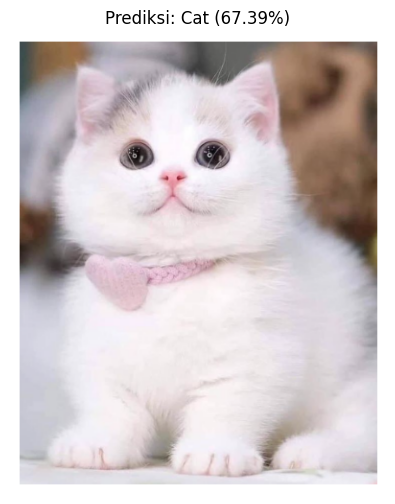

Hasil Prediksi: Cat dengan probabilitas 67.39%


In [37]:
# Import library yang diperlukan
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import cv2
from PIL import Image
import os

# Definisikan path SavedModel
saved_model_dir = 'saved_model'

# Verifikasi keberadaan SavedModel
if not os.path.exists(saved_model_dir):
    raise FileNotFoundError(f"Direktori SavedModel '{saved_model_dir}' tidak ditemukan.")

# Periksa isi direktori SavedModel
print(f"Isi direktori {saved_model_dir}:")
for item in os.listdir(saved_model_dir):
    print(f"- {item}")

# Periksa signature SavedModel
try:
    loaded_model = tf.saved_model.load(saved_model_dir)
    signatures = list(loaded_model.signatures.keys())
    print("\nSignature yang tersedia:", signatures)
    if 'serving_default' in signatures:
        print("Input signature:", loaded_model.signatures['serving_default'].structured_input_signature)
        print("Output signature:", loaded_model.signatures['serving_default'].structured_outputs)
    else:
        print("Peringatan: Signature 'serving_default' tidak ditemukan!")
except Exception as e:
    print(f"Error saat memeriksa signature SavedModel: {e}")
    raise

# Muat model dari format SavedModel sebagai inference layer
try:
    inference_layer = tf.keras.layers.TFSMLayer(saved_model_dir, call_endpoint='serving_default')
    print("Model SavedModel berhasil dimuat sebagai inference layer.")
except Exception as e:
    print(f"Error saat memuat model SavedModel: {e}")
    raise

# Definisikan parameter
IMG_SIZE = 128  # Ukuran gambar sesuai pelatihan
class_names = ['Cat', 'Dog']  # Mapping kelas

# Fungsi untuk memproses gambar baru
def preprocess_image(image_path):
    try:
        # Baca gambar dengan OpenCV
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Gagal membaca gambar.")

        # Konversi ke RGB (OpenCV menggunakan BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Ubah ukuran ke 128x128
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Normalisasi (0-1)
        img = img / 255.0

        # Tambahkan dimensi batch (1, 128, 128, 3)
        img = np.expand_dims(img, axis=0).astype(np.float32)

        # Validasi bentuk input
        if img.shape != (1, IMG_SIZE, IMG_SIZE, 3):
            raise ValueError(f"Bentuk input tidak valid: {img.shape}. Harus (1, {IMG_SIZE}, {IMG_SIZE}, 3).")

        print(f"Bentuk input tensor: {img.shape}, dtype: {img.dtype}")
        return img
    except Exception as e:
        print(f"Error saat memproses gambar: {e}")
        return None

# Fungsi untuk memprediksi dan menampilkan hasil
def predict_and_display(image_path, inference_layer, class_names):
    # Proses gambar
    img_array = preprocess_image(image_path)
    if img_array is None:
        return

    # Prediksi
    try:
        # Kirim input sebagai tensor langsung
        prediction = inference_layer(img_array)  # Tanpa dictionary, sesuai signature
        prediction = prediction['output_0']  # Nama output sesuai signature
        pred_class = int(prediction[0] > 0.5)  # >0.5 = Dog, <=0.5 = Cat
        pred_label = class_names[pred_class]
        pred_prob = prediction[0][0] if pred_class == 1 else 1 - prediction[0][0]

        # Tampilkan gambar dan hasil prediksi
        img = Image.open(image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Prediksi: {pred_label} ({pred_prob*100:.2f}%)")
        plt.axis('off')
        plt.show()

        print(f"Hasil Prediksi: {pred_label} dengan probabilitas {pred_prob*100:.2f}%")
    except Exception as e:
        print(f"Error saat memprediksi: {e}")

# Unggah gambar baru
print("\nSilakan unggah gambar Cat atau Dog (format .jpg, .png, atau .jpeg):")
uploaded = files.upload()

# Proses setiap gambar yang diunggah
for file_name, file_content in uploaded.items():
    print(f"\nMemproses gambar: {file_name}")
    with open(file_name, 'wb') as f:
        f.write(file_content)
    predict_and_display(file_name, inference_layer, class_names)

## **Inference (Optional)**

In [38]:
#Melakukan inventarisasi library yang digunakan dan tidak digunakan
import pkg_resources
import os

# Daftar library yang digunakan
used_libraries = [
    'tensorflow',  # Untuk model Keras dan TFLite
    'tensorflowjs',  # Untuk konversi ke TFJS
    'numpy',  # Untuk manipulasi array
    'opencv-python',  # Untuk pemrosesan gambar (cv2)
    'pillow',  # Untuk memproses gambar baru (PIL)
    'matplotlib',  # Untuk visualisasi (plotting)
    'pandas',  # Untuk DataFrame
    'scikit-learn',  # Untuk train_test_split
    'seaborn',  # Untuk visualisasi confusion matrix
]

# Daftar library yang tidak diperlukan untuk inference
# (digunakan hanya untuk training atau preprocessing)
unused_for_inference = [
    'pandas',  # Tidak diperlukan untuk inference
    'scikit-learn',  # Hanya untuk splitting dataset
    'seaborn',  # Hanya untuk visualisasi evaluasi
    'matplotlib',  # Hanya untuk plotting
]

# Filter library untuk inference
inference_libraries = [lib for lib in used_libraries if lib not in unused_for_inference]

# Dapatkan versi library yang terinstal
installed_packages = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
requirements = []

print("Library yang digunakan untuk inference:")
for lib in inference_libraries:
    version = installed_packages.get(lib, 'tidak ditemukan')
    requirements.append(f"{lib}=={version}")
    print(f"- {lib}=={version}")

# Tambahkan library tambahan untuk kompatibilitas (jika diperlukan)
# Misalnya, opencv-python sering membutuhkan opencv-python-headless untuk lingkungan tertentu
if 'opencv-python' in inference_libraries:
    opencv_headless = 'opencv-python-headless'
    version = installed_packages.get(opencv_headless, installed_packages.get('opencv-python', 'tidak ditemukan'))
    requirements.append(f"{opencv_headless}=={version}")
    print(f"- {opencv_headless}=={version}")



Library yang digunakan untuk inference:
- tensorflow==2.18.0
- tensorflowjs==4.22.0
- numpy==2.0.2
- opencv-python==4.11.0.86
- pillow==11.2.1
- opencv-python-headless==4.11.0.86


In [39]:
#Download Berkas untuk digunakan Testing dan lampiran Submission
# Simpan ke requirements.txt
requirements_file = 'requirements.txt'
with open(requirements_file, 'w') as f:
    for req in requirements:
        f.write(f"{req}\n")

# Verifikasi dan tampilkan isi file
print(f"\nFile '{requirements_file}' telah dibuat.")
print("Isi requirements.txt:")
with open(requirements_file, 'r') as f:
    print(f.read())

# Periksa ukuran file
file_size = os.path.getsize(requirements_file) / 1024  # Ukuran dalam KB
print(f"Ukuran file requirements.txt: {file_size:.2f} KB")


File 'requirements.txt' telah dibuat.
Isi requirements.txt:
tensorflow==2.18.0
tensorflowjs==4.22.0
numpy==2.0.2
opencv-python==4.11.0.86
pillow==11.2.1
opencv-python-headless==4.11.0.86

Ukuran file requirements.txt: 0.12 KB
